# letters: 0-255, spacer:256, blank(e):257

In [41]:
BLANK_VAL = 257

#! Tin 
from IPython.display import clear_output  
import randomizeSequence as rSeq
import ScrappySequence as ss
import math
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

#!/usr/bin/env python
import os
import json
import time
import argparse
from tqdm import tqdm
from collections import defaultdict
import math
import argparse
import importlib

# torchim:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
# from tensorboardX import SummaryWriter
import numpy as np
import pytorch_warmup as warmup

# data:
import data
from data.collate import collate_fn, gpu_collate, no_pad_collate
from data.transforms import (
    Compose, AddLengths, AudioSqueeze, TextPreprocess,
    MaskSpectrogram, ToNumpy, BPEtexts, MelSpectrogram,
    ToGpu, Pad, NormalizedMelSpectrogram
)
import youtokentome as yttm

import torchaudio
from audiomentations import (
    TimeStretch, PitchShift, AddGaussianNoise
)
from functools import partial

# model:
from model import configs as quartznet_configs
from model.quartznet import QuartzNet

# utils:
import yaml
from easydict import EasyDict as edict
from utils import fix_seeds, remove_from_dict, prepare_bpe
import wandb
from decoder import GreedyDecoder, BeamCTCDecoder

import youtokentome as yttm
from gen_data_func import *


In [42]:
dna_vocab = [f"_{x}_" for x in range(256)]#.append(['spacer','blank'])
dna_vocab.append('spacer')
dna_vocab.append('blank')
dna_vocab.append('_')
print(dna_vocab)
print(dna_vocab[255])

['_0_', '_1_', '_2_', '_3_', '_4_', '_5_', '_6_', '_7_', '_8_', '_9_', '_10_', '_11_', '_12_', '_13_', '_14_', '_15_', '_16_', '_17_', '_18_', '_19_', '_20_', '_21_', '_22_', '_23_', '_24_', '_25_', '_26_', '_27_', '_28_', '_29_', '_30_', '_31_', '_32_', '_33_', '_34_', '_35_', '_36_', '_37_', '_38_', '_39_', '_40_', '_41_', '_42_', '_43_', '_44_', '_45_', '_46_', '_47_', '_48_', '_49_', '_50_', '_51_', '_52_', '_53_', '_54_', '_55_', '_56_', '_57_', '_58_', '_59_', '_60_', '_61_', '_62_', '_63_', '_64_', '_65_', '_66_', '_67_', '_68_', '_69_', '_70_', '_71_', '_72_', '_73_', '_74_', '_75_', '_76_', '_77_', '_78_', '_79_', '_80_', '_81_', '_82_', '_83_', '_84_', '_85_', '_86_', '_87_', '_88_', '_89_', '_90_', '_91_', '_92_', '_93_', '_94_', '_95_', '_96_', '_97_', '_98_', '_99_', '_100_', '_101_', '_102_', '_103_', '_104_', '_105_', '_106_', '_107_', '_108_', '_109_', '_110_', '_111_', '_112_', '_113_', '_114_', '_115_', '_116_', '_117_', '_118_', '_119_', '_120_', '_121_', '_122_', '_

In [43]:
#! 

class DNA_vocab:
    # character and index is the same for this task    
    def __init__(self, dna_vocab):
        self.dna_vocab = dna_vocab
    def vocab(self):
        return dna_vocab
    def id_to_subword(self,id):
        return dna_vocab[id]

In [44]:
class AudioUnsqueeze:
    def __call__(self, data):
        data['audio'] = data['audio'].unsqueeze(1)
        return data

In [45]:
print(os.getcwd())
data_file_name = "out_csv/testing_out.csv"
samples_per_sequence = 3

c:\Users\nntin\uni\fyp\fyp2023


In [46]:
start = time.monotonic()
signals,index,spacer_labels, letter_labels, barcode_labels, ctc_labels =prepare_train2(data_file_name, samples_per_sequence)
end = time.monotonic()
print(f"Generated {len(signals)} signals and {len(spacer_labels)} labels", f"in {end-start}")
#Sequential: 26.099690708000026

Sequence 3 of 3
Generated 9 signals and 9 labels in 0.031000000017229468


Letters: [89, 56, 165, 40, 132, 143, 174] 
barcodes: [1, 2] 
ctc_labels: [256, 89, 256, 56, 256, 165, 256, 40, 256, 132, 256, 143, 256, 174, 256]
9
[1975, 1727, 1836, 1839, 1936, 1953, 1989, 2106, 2070]
2106


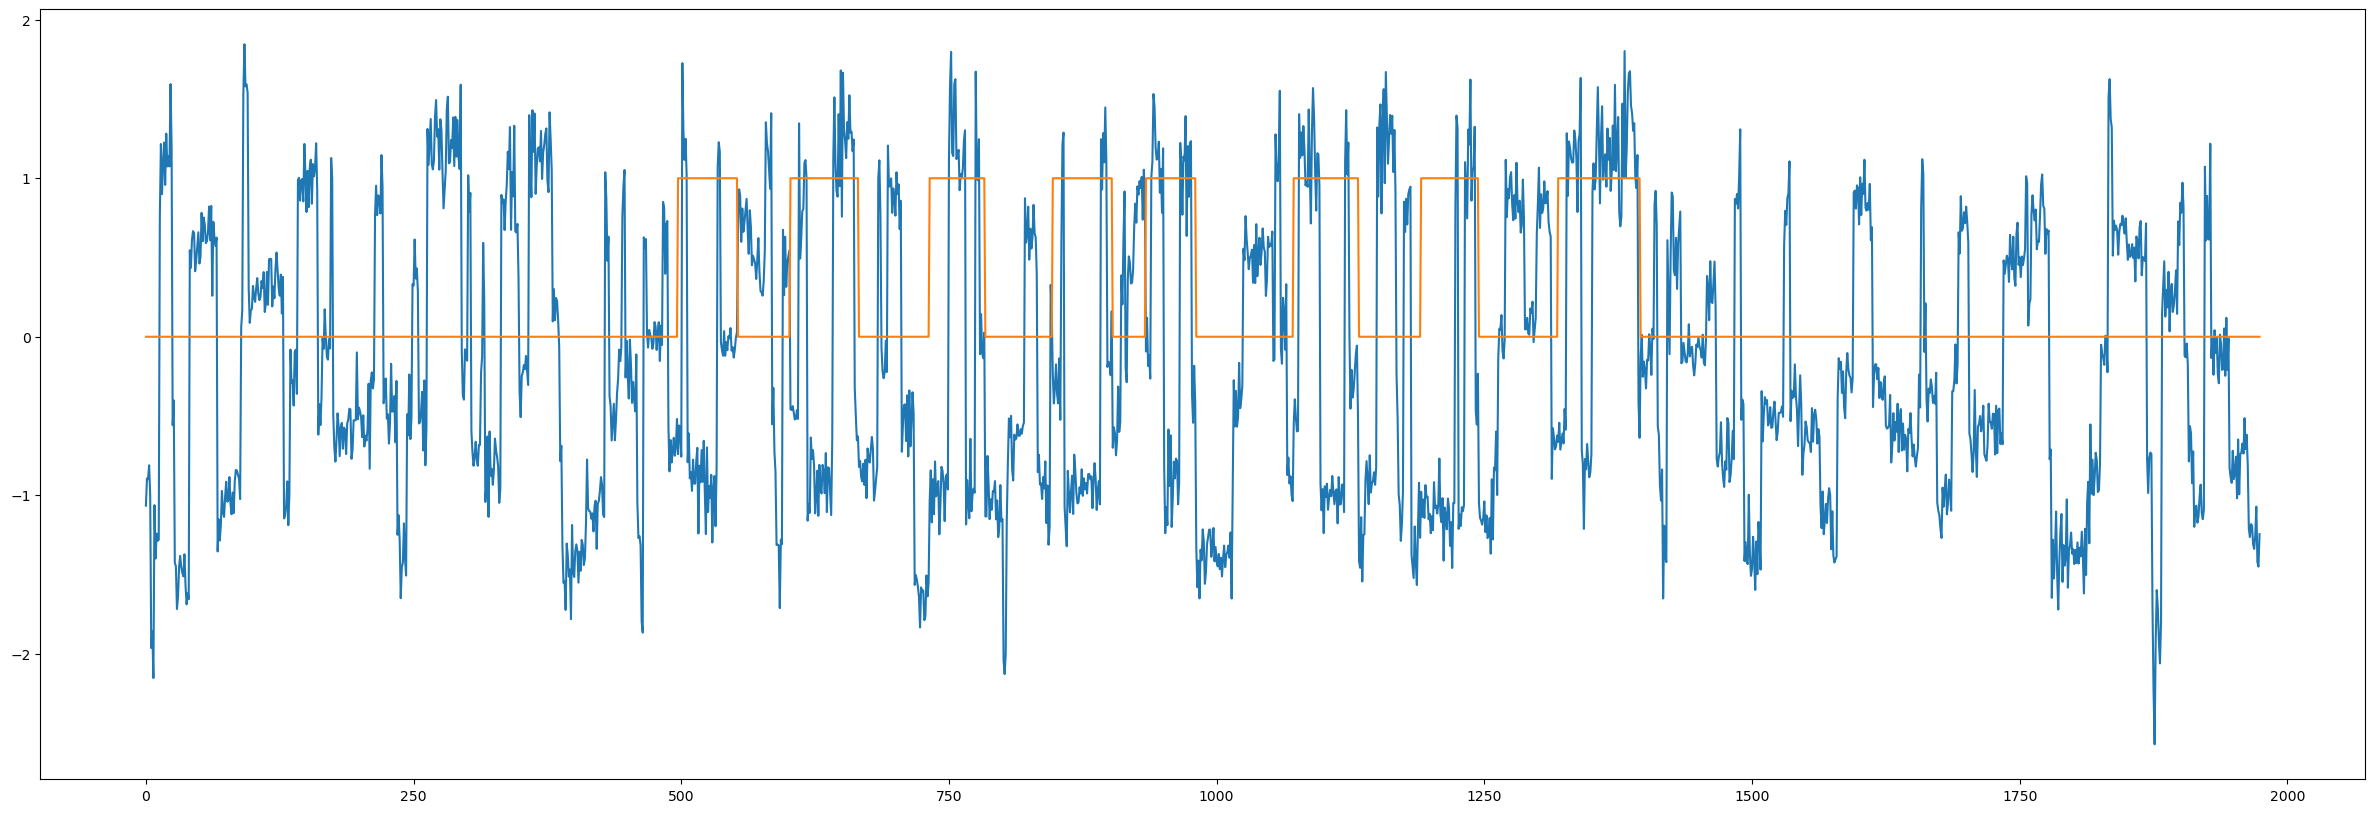

In [47]:
plt.figure(figsize=(30, 10))
i  = 0
plt.plot(signals[i])
plt.plot(spacer_labels[i])
print("Letters:", letter_labels[i], "\nbarcodes:", barcode_labels[i], '\nctc_labels:', ctc_labels[i])

print(len(signals))
# print(len(signals[i]))
print(([len(x) for x in signals]))
print(max([len(x) for x in signals]))

In [48]:
#Create a "SignalDataset" class by importing the Pytorch Dataset class
class Dataset_ctc(Dataset):
    """ Data noisey sinewave dataset
        num_datapoints - the number of datapoints you want
    """
    def __init__(self, x,y):
        self.x_data = x
        self.y_data = y

    #called by the dataLOADER class whenever it wants a new mini-batch
    #returns corresponding input datapoints AND the corresponding labels
    def __getitem__(self, index):
        return {'audio': np.array(self.x_data[index]), 'text': np.array(self.y_data[index]), 'sample_rate': 22050}
        
    #length of the dataset
    def __len__(self):
        return len(self.x_data)

In [49]:

# TODO: wrap to trainer class

parser = argparse.ArgumentParser(description='Training model.')
parser.add_argument('--config', default='configs/train_LJSpeech.yaml',
                    help='path to config file')
args = parser.parse_args("")
with open(args.config, 'r') as f:
    config = edict(yaml.safe_load(f))

def write_to_file(str_w, file_name = 'sth.txt', mode = 'w'):
    with open(file_name,mode) as f:
        f.write(str(str_w))

In [50]:
config

{'dataset': {'root': 'DB/LJspeech',
  'train_part': 0.95,
  'name': 'ljspeech',
  'sample_rate': 22050},
 'bpe': {'train': True, 'model_path': 'yttm.bpe'},
 'train': {'seed': 42,
  'num_workers': 1,
  'batch_size': 8,
  'clip_grad_norm': 15,
  'epochs': 42,
  'optimizer': {'lr': 0.0005, 'weight_decay': 0.0001}},
 'wandb': {'project': 'quartznet_ljspeech', 'log_interval': 20},
 'model': {'name': '_quartznet5x5_config', 'vocab_size': 258, 'feat_in': 1}}

In [51]:
fix_seeds(seed=config.train.get('seed', 42))
dataset_module = importlib.import_module(
    f'.{config.dataset.name}', data.__name__)
bpe = prepare_bpe(config)
bpe = DNA_vocab(dna_vocab)

transforms_train = Compose([
    # TextPreprocess(),# removing punctuation in text - might not needed
    # ToNumpy(), # convert audio to numpy
    # BPEtexts(bpe=bpe, dropout_prob=config.bpe.get('dropout_prob', 0.05)),
    # AudioSqueeze(), # remove 1st dimension if it is 1 [1,...]
    # AddGaussianNoise(
    #     min_amplitude=0.001,
    #     max_amplitude=0.015,
    #     p=0.5
    # ),
    # TimeStretch(
    #     min_rate=0.8,
    #     max_rate=1.25,
    #     p=0.5
    # ),
    # PitchShift(
    #     min_semitones=-4,
    #     max_semitones=4,
    #     p=0.5
    # )
    # AddLengths()
])

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get('sample_rate', 16000),
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    # MaskSpectrogram(
    #     probability=0.5,
    #     time_mask_max_percentage=0.05,
    #     frequency_mask_max_percentage=0.15
    # ),
    AddLengths(),
    Pad(),
    AudioUnsqueeze() #! Tin add
])

transforms_val = Compose([
#     TextPreprocess(),
#     ToNumpy(),
#     BPEtexts(bpe=bpe),
#     AudioSqueeze()
])

batch_transforms_val = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get(
    #         'sample_rate', 16000),  # for LJspeech
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    AddLengths(),
    Pad(), # pad both audio and text
    AudioUnsqueeze() #! Tin add
])

# load datasets
# train_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_train, part='train')
# val_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_val, part='val')

# ! TIN Dataset
train_dataset = Dataset_ctc(signals,ctc_labels)
val_dataset = Dataset_ctc(signals,ctc_labels)

# print("!!!", config.train.get('num_workers', 4))
train_dataloader = DataLoader(train_dataset, 
                                batch_size=config.train.get('batch_size', 1), collate_fn=no_pad_collate)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=1, collate_fn=no_pad_collate)

# print(getattr(quartznet_configs, config.model.name, '_quartznet5x5_config'))

model = QuartzNet(
    model_config=getattr(
        quartznet_configs, config.model.name, '_quartznet5x5_config'),
    **remove_from_dict(config.model, ['name'])
)
# model = QuartzNet(
#     model_config=getattr(
#         quartznet_configs, config.model.name, '_quartznet5x5_config'),**config)


# print(model)
write_to_file(model,'model_structure.txt')

optimizer = torch.optim.Adam(
    model.parameters(), **config.train.get('optimizer', {}))
num_steps = len(train_dataloader) * config.train.get('epochs', 10)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_steps)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

if config.train.get('from_checkpoint', None) is not None:
    model.load_weights(config.train.from_checkpoint)

if torch.cuda.is_available():
    model = model.cuda()


criterion = nn.CTCLoss(blank=BLANK_VAL, reduction='mean', zero_infinity=True)
# criterion = nn.CTCLoss(blank=config.model.vocab_size)
decoder = GreedyDecoder(bpe=bpe,blank_index=BLANK_VAL,space_simbol='_')

prev_wer = 1000
#! TIN CHNAGE
wandb.init(project=config.wandb.project, config=config)
wandb.watch(model, log="all", log_freq=config.wandb.get(
    'log_interval', 5000))

label
['_0_', '_1_', '_2_', '_3_', '_4_', '_5_', '_6_', '_7_', '_8_', '_9_', '_10_', '_11_', '_12_', '_13_', '_14_', '_15_', '_16_', '_17_', '_18_', '_19_', '_20_', '_21_', '_22_', '_23_', '_24_', '_25_', '_26_', '_27_', '_28_', '_29_', '_30_', '_31_', '_32_', '_33_', '_34_', '_35_', '_36_', '_37_', '_38_', '_39_', '_40_', '_41_', '_42_', '_43_', '_44_', '_45_', '_46_', '_47_', '_48_', '_49_', '_50_', '_51_', '_52_', '_53_', '_54_', '_55_', '_56_', '_57_', '_58_', '_59_', '_60_', '_61_', '_62_', '_63_', '_64_', '_65_', '_66_', '_67_', '_68_', '_69_', '_70_', '_71_', '_72_', '_73_', '_74_', '_75_', '_76_', '_77_', '_78_', '_79_', '_80_', '_81_', '_82_', '_83_', '_84_', '_85_', '_86_', '_87_', '_88_', '_89_', '_90_', '_91_', '_92_', '_93_', '_94_', '_95_', '_96_', '_97_', '_98_', '_99_', '_100_', '_101_', '_102_', '_103_', '_104_', '_105_', '_106_', '_107_', '_108_', '_109_', '_110_', '_111_', '_112_', '_113_', '_114_', '_115_', '_116_', '_117_', '_118_', '_119_', '_120_', '_121_', '_122

In [52]:
print(bpe.vocab())
bpe.vocab().index('_')
int_to_char = bpe.id_to_subword
int_to_char(257)

['_0_', '_1_', '_2_', '_3_', '_4_', '_5_', '_6_', '_7_', '_8_', '_9_', '_10_', '_11_', '_12_', '_13_', '_14_', '_15_', '_16_', '_17_', '_18_', '_19_', '_20_', '_21_', '_22_', '_23_', '_24_', '_25_', '_26_', '_27_', '_28_', '_29_', '_30_', '_31_', '_32_', '_33_', '_34_', '_35_', '_36_', '_37_', '_38_', '_39_', '_40_', '_41_', '_42_', '_43_', '_44_', '_45_', '_46_', '_47_', '_48_', '_49_', '_50_', '_51_', '_52_', '_53_', '_54_', '_55_', '_56_', '_57_', '_58_', '_59_', '_60_', '_61_', '_62_', '_63_', '_64_', '_65_', '_66_', '_67_', '_68_', '_69_', '_70_', '_71_', '_72_', '_73_', '_74_', '_75_', '_76_', '_77_', '_78_', '_79_', '_80_', '_81_', '_82_', '_83_', '_84_', '_85_', '_86_', '_87_', '_88_', '_89_', '_90_', '_91_', '_92_', '_93_', '_94_', '_95_', '_96_', '_97_', '_98_', '_99_', '_100_', '_101_', '_102_', '_103_', '_104_', '_105_', '_106_', '_107_', '_108_', '_109_', '_110_', '_111_', '_112_', '_113_', '_114_', '_115_', '_116_', '_117_', '_118_', '_119_', '_120_', '_121_', '_122_', '_

'blank'

In [53]:
b=train_dataset.__getitem__(2)
b['audio'].shape

(1836,)

In [54]:
a=next(iter(train_dataloader))
print(len(a))
print(len(a['audio']))
print(len(a['text']))
print(len(a['audio'][0]))
# print(len(a['text'][1]))

b=batch_transforms_train(a)
print(len(b))
print(len(b['audio']))
print(len(b['text']))
print((b['audio']).shape)
print((b['input_lengths']))
print((b['target_lengths']))
print(b['text'].shape)

print(b['audio'].dtype)
print(b['text'].dtype)


3
8
8
1975
5
8
8
torch.Size([8, 1, 2106])
tensor([1975, 1727, 1836, 1839, 1936, 1953, 1989, 2106], device='cuda:0')
tensor([15, 15, 15, 15, 15, 15, 15, 15], device='cuda:0')
torch.Size([8, 15])
torch.float64
torch.int32


In [55]:
print(b.keys())

dict_keys(['audio', 'text', 'sample_rate', 'input_lengths', 'target_lengths'])


In [56]:

for epoch_idx in tqdm(range(config.train.get('epochs', 10))):
    # train:
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
        batch1=batch
        # print(len(batch1['audio'][0]))
        batch = batch_transforms_train(batch)
        batch2=batch
        # print(len(batch2['audio'][0]))

        optimizer.zero_grad()
        logits = model(batch['audio'].float())
        
        output_length = torch.ceil(
            batch['input_lengths'].float() / model.stride).int()
        
        # print('batch audio shape:', batch['audio'].shape, batch['audio'].dtype )
        # print('logits shape:', logits.shape)
        # print('output_length shape:',output_length)
        # print('target_lengths:',batch['target_lengths'])
        
        loss = criterion(logits.permute(2, 0, 1).log_softmax(
            dim=2), batch['text'], output_length, batch['target_lengths']) # target_length is the length of text of batch1 (before batch aug)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), config.train.get('clip_grad_norm', 15))
        optimizer.step()
        lr_scheduler.step()
        # warmup_scheduler.dampen()
        # break
        if batch_idx % config.wandb.get('log_interval', 5000) == 0:
            target_strings = decoder.convert_to_strings(batch['text'])
            decoded_output = decoder.decode(
                logits.permute(0, 2, 1).softmax(dim=2))
            wer = np.mean([decoder.wer(true, pred)
                            for true, pred in zip(target_strings, decoded_output)])
            cer = np.mean([decoder.cer(true, pred)
                            for true, pred in zip(target_strings, decoded_output)])
            step = epoch_idx * \
                len(train_dataloader) * train_dataloader.batch_size + \
                batch_idx * train_dataloader.batch_size
            #! TIN change
            wandb.log({
                "train_loss": loss.item(),
                "train_wer": wer,
                "train_cer": cer,
                "train_samples": wandb.Table(
                    columns=['gt_text', 'pred_text'],
                    data=list(zip(target_strings, decoded_output))
                )
            }, step=step)
        # print(decoded_output)
    # #!
    # validate:
    model.eval()
    val_stats = defaultdict(list)
    for batch_idx, batch in enumerate(val_dataloader):
        batch = batch_transforms_val(batch)
        with torch.no_grad():
            logits = model(batch['audio'])
            output_length = torch.ceil(
                batch['input_lengths'].float() / model.stride).int()
            loss = criterion(logits.permute(2, 0, 1).log_softmax(
                dim=2), batch['text'], output_length, batch['target_lengths'])

        target_strings = decoder.convert_to_strings(batch['text'])
        decoded_output = decoder.decode(
            logits.permute(0, 2, 1).softmax(dim=2))
        wer = np.mean([decoder.wer(true, pred)
                        for true, pred in zip(target_strings, decoded_output)])
        cer = np.mean([decoder.cer(true, pred)
                        for true, pred in zip(target_strings, decoded_output)])
        val_stats['val_loss'].append(loss.item())
        val_stats['wer'].append(wer)
        val_stats['cer'].append(cer)
    for k, v in val_stats.items():
        val_stats[k] = np.mean(v)
    val_stats['val_samples'] = wandb.Table(
        columns=['gt_text', 'pred_text'], data=list(zip(target_strings, decoded_output)))
    wandb.log(val_stats, step=step)

    # save model, TODO: save optimizer:
    if val_stats['wer'] < prev_wer:
        os.makedirs(config.train.get(
            'checkpoint_path', 'checkpoints'), exist_ok=True)
        prev_wer = val_stats['wer']
        torch.save(
            model.state_dict(),
            os.path.join(config.train.get(
                'checkpoint_path', 'checkpoints'), f'model_{epoch_idx}_{prev_wer}.pth')
        )
        wandb.save(os.path.join(config.train.get(
            'checkpoint_path', 'checkpoints'), f'model_{epoch_idx}_{prev_wer}.pth'))
    # break

  2%|▏         | 1/42 [00:01<00:42,  1.03s/it]

['_33__221__31__114__157__248__141__129__59__46__166__129__95__31__243__49__141__58__46__128__129__48__128__203__31__129__211__82__225__129__101__49__202__157__80__49__14__129__242__87__225__129__76__54__144__239__129__107__51__77__141__129__75__129__49__58__189__49__129__46__169__45__49__132_spacer_181__251__118__89__49__48__155__49__45__132__157__81__14__8__129__59__221__241__159__40__151__54__190__225__48__129__141__118__181__54__90__60__150__151__24__239__237__101__169__97__85__141__232__202__221__71__129__103__22__101__46__11__150__6__189__22__104__32__143__193__169__54__84__22__95__211__141__98_spacer_14__234__14__68__158__129__185__140__159__234__31__193__49__84__150__189__152__128__130__157__236__216__150__128__236__49__45__198__98__169__84__129__159__150__206__151__141__54__129__255__65__217__141__235__141__155__255__88__193__255__118__234__122__141__202__100__48__57__6__129__122__46__54__20__92__8__54__22__66__129__222__13__201__128__101__151__118__240__84__230__129__144__181

  5%|▍         | 2/42 [00:01<00:37,  1.08it/s]

['_89__14__167__151__89__143__245__209__179__132__89__31__89__190__43__35__129__107__24__48__130__101__245__195__255__141__152__89__239__118__129__101__154__141__132_spacer_89_spacer_202__82__89__128_spacer_129__128__200__189__129__255__82__78__25__145__95_spacer_129__22__195__89__84__89__82__132__170__89__193__118__89__203__165__32__158__64__132__239__150__132__156__89__14__12__132__81__78__40__12__40__131__129__95__132__105__132__101__196__255__195__137__101__24__118__169__150__169__131__129__169__225__169__81__132__169__118__169__165__197__72__48__141__129__164__89__169__239__125__89__169__33__79__129__32__128__60__169__132__169__101__93__165__56__54__206__169__211__169__202__169__129__169__118__132__205__169__203__169__60__169__129__169__141__129__14__169__181__169__229__132__49__169__159__169__123__62__200__234__255__71__14__165__169__118__35__169__190_spacer_169__201__169__105__78__81__169__195__129__169__15__241__255__225__10__169__114__99_spacer_169__46__169__40__165__14__189__

  7%|▋         | 3/42 [00:02<00:34,  1.14it/s]

['_89_spacer_89_spacer_89_spacerspacer_89_spacer_89_spacer_89_spacer_89_spacer_129__89_spacer_89_spacer_89_spacer_214__89_spacer_129__89_spacer_89_spacer_40__82_spacer_164__141__189_spacer_89__132__141__89__101__40__46__132__89__169__89__132__169__132__169__123__169__40__169__141__169__169__89__169__89__169__89__169__132__169__141__169__40__169__159__169__132__169__46__126__129__62__169__159__82__169_spacer_151__118__169_spacer_132__169_spacer_159__169_spacer_211__169_spacer_101__49_spacer_169_spacer_141__118__40__129_spacer_118_spacer_254_spacer_141_spacer_89__14_spacerspacer_40_spacer_89_spacer_89_spacer_159_spacer_89_spacer_89_spacer_101_spacer_132_spacer_231_spacer_132_spacer_89_spacer_144__211__150_spacer_169__89_spacer_132_spacer_5_spacer_255_spacer_48_spacer_231_spacer_129_spacer_84_spacer_200_spacer_157_spacer_132__40__254_spacer_169_spacer_132_spacer_81__89__46_spacer_114__150__169__129_spacer_200__205__40__59__235__169__40__247__89_spacer_151_spacer_132__169_spacer_159_spacer

 10%|▉         | 4/42 [00:03<00:32,  1.17it/s]

['spacer_89_spacer_89_spacer_89_spacer_89_spacer_89_spacer_89_spacer_89_spacer_89_spacer_89__89__169__89_spacer_169__132__89__169__89__169__132__132__169__132__89__132__169__132__169__89__169__132__169__89__169__89__169__169__132__169__132__169__132__169__132__169__62__169__89__169__159__169__71__169_spacer_169__132__169_spacer_169_spacer_169__89__169_spacer_132_spacer_169_spacerspacer_169_spacerspacer_89_spacer_89_spacer_169_spacer_89_spacer_169__89_spacer_132_spacer_211_spacer_132_spacer_132_spacer_132_spacer_169__89__132__169__48__169__132__169__132__169__132__169__62__132__169__132__169__159__169__14__169__132__169__62__169_spacer_169_spacer_169__132__169__132__169__132_spacer_169_spacer_132__169_spacer_169_spacer', 'spacer_89_spacer_89_spacer_89_spacerspacer_89_spacer_132_spacer_169__89_spacer_169_spacer_169_spacer_132_spacer_132_spacer_89_spacer_89_spacer_169__132_spacer_169_spacer_89_spacer_169_spacer_132_spacer_182_spacer_132__169_spacer_169_spacer_40__169_spacer_169_spacer_169

 12%|█▏        | 5/42 [00:04<00:31,  1.19it/s]

['spacer_89_spacer_89__89_spacer_89_spacer_89__132__89__169__89__169__169__132__89__169__89__169__169__132__169__89__169__132__169__132__169__132__169__132__169_spacer_169_spacer_169_spacer_169_spacer_169__132_spacer_169__71__169_spacer_169__169__132__169__89__169__89__169__62__169__132__169_spacer_169_spacer_169_spacer_169_spacer', 'spacer_132_spacer_169_spacer_169_spacer_132_spacer_132__169_spacer_169__89__169__132__169__169__89__169__169_spacer_169__132__169__89__169__132__169__89__89__169__132__169__132__89__169__132__169_spacer_89__169__132__169__89__169__89__169__132__169__132__169_spacer_169__132__169__89__169_spacer_169__132_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169__132_spacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacer_89_spacer_89_spacer_89_spacerspacer_89_spacerspacer_169_spacerspacer_169__169__89__169__169__132__169__132__169__89__169__132__169__169__132__169__132__169__132__169_spacer_169_spacer_169_spacer_169_spacer', 's

 14%|█▍        | 6/42 [00:05<00:30,  1.20it/s]

['spacer_89_spacer_89_spacerspacer_89__89__169__89_spacer_169__169__169__169__132__169__132__169__132__169__132__169__169__132__169__132__132__169__132__169__132__169__132__169__132__169_spacer_169_spacer_169_spacer_169__169__132__169_spacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169__89__169__169__89__132__169__169__169__132__169__132__169__169__132__169__132__169_spacer_169_spacer_169_spacer', 'spacer_169_spacer_169_spacer_169_spacer_169__132__169__132__169__132__169__132__169__169__132__169__169__132__169__132__169__132__169__132_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer', '_89__89__89__89__89__169__89__169__89__89__89__169__89__89__169__89__169__169__89__169__89__169__169__132__169__132__169__132__169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_16

 17%|█▋        | 7/42 [00:05<00:28,  1.21it/s]

['spacer_89_spacer_169_spacer_169__89__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__132__169_spacer_169_spacer_169_spacer_169__169__169__132__169_spacer_169_spacer_169_spacer_169_spacer', 'spacer_169_spacer_169_spacer_169_spacer', 'spacer_169_spacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacer_169_spacer_169_spacer', 'spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__132__169__132__169__132__169_spacer_169_spacer_169_spacer_169_spacer_132_spacer', 'spacerspacerspacerspacerspacerspacer_169__89__169__169_spacer_169__169__169__169_spacer_169_spacer_169__169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_space

 19%|█▉        | 8/42 [00:06<00:27,  1.22it/s]

['spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacer_169_spacer_169_spacerspacer_169_spacer_169__169__169__169__169__169__132__169__132__169__132__169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169__169__169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacer_169_spacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__132__169_spacer_169_spacer_169_spacer', 'spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__132__169__169__169__169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacers

 21%|██▏       | 9/42 [00:07<00:26,  1.22it/s]

['spacerspacerspacerspacerspacer_169__169_spacerspacer_169_spacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169_spacer_169_spacer_169_spacer_169_spacer', 'spacer_169_spacerspacer_169_spacerspacer_169_spacerspacerspacerspacerspacerspacer_169_spacerspacerspacer', 'spacerspacerspacer_169__169_spacerspacerspacerspacerspacerspacerspacer_169_spacerspacerspacerspacerspacer', 'spacer_169_spacerspacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacer_169_spacerspacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacer_169_spacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169_spacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_1

 24%|██▍       | 10/42 [00:08<00:26,  1.23it/s]

['spacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacer', 'spacerspacer_169__169__169__169__169_spacerspacerspacerspacer', 'spacerspacer_169__169_spacer_169_spacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacer_169_spacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacer_169__169__169__169_spacer_169_spacer_169_spacer_169_spacer_169__169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacer_169__169__169__169__169__169__169__169__169__169__169_spacer_169_spacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacer_169_space

 26%|██▌       | 11/42 [00:09<00:25,  1.24it/s]

['spacerspacerspacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacer', 'spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacer_169_spacerspacer_169_spacer', 'spacerspacer_169_spacerspacer', 'spacerspacerspacer_169_spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacer_169_spacerspacerspacerspacerspacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacer_169_spacer_169_spacer']
['spacerspacerspacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169_

 29%|██▊       | 12/42 [00:09<00:24,  1.25it/s]

['spacerspacerspacerspacerspacer_169__169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacer', 'spacer_169_spacer_169__169__169__169__169__169__169__169_spacer_169_spacer', 'spacerspacer_169__169__169_spacer', 'spacer', 'spacerspacerspacerspacerspacerspacerspacerspacer_169__169__169_spacerspacer_169__169__169__169__169__169__169__169_spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacer_169_spacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacer_169__169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacerspacer', 'spacerspacerspa

 31%|███       | 13/42 [00:10<00:23,  1.25it/s]

['spacerspacerspacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacer', 'spacerspacerspacer_169_spacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169__169__169__169__169__169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__

 33%|███▎      | 14/42 [00:11<00:22,  1.24it/s]

['spacerspacerspacerspacerspacerspacerspacer_169__169__169__169_spacer_169_spacer_169_spacer_169_spacer', 'spacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacerspacerspacer_169__169__169__169_spacer_169_spacer_169_spacer_169_spacer', 'spacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__1

 36%|███▌      | 15/42 [00:12<00:21,  1.24it/s]

['spacerspacerspacerspacerspacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacerspacer', 'spacer', 'spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169_spacer_169__169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacer_169_spacer_169__169_spacerspacerspacer', 'spacer', 'spacerspacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacer_169__169__169__169__169__169__169__169__169__169__169__169__169__169_spacerspacer', 'spacer', 'spacer_169_spacer_169__169__169__169__169__169__169__169__169__169__169__169_spacer_169__169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacer_169_spacer_169__169_spacerspacerspacer', 'spacer', 'spacerspacer_169_spacer_169_spacer_169_spacer_16

 38%|███▊      | 16/42 [00:13<00:20,  1.24it/s]

['spacerspacerspacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169__169__169__169_spacerspacer', 'spacerspacerspacerspacerspacerspacerspacer', 'spacerspacer_169_spacer_169__169__169__169__169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacer_169_spacerspacer_169_spacer_169_spacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169__169__169__169_spacerspacer', 'spacerspacerspacerspacerspacerspacerspacer', 'spacerspacer_169_spacer_169__169__169__169__169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacerspacer', 'spacers

 40%|████      | 17/42 [00:14<00:20,  1.24it/s]

['spacerspacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer']


 43%|████▎     | 18/42 [00:14<00:19,  1.24it/s]

['spacerspacerspacerspacerspacer_169__169__169_spacerspacer', 'spacer', 'spacer_169_spacerspacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacer', 'spacer', 'spacerspacer_169__169__169__169_spacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacer_169__169__169_spacerspacer', 'spacer', 'spacer_169_spacerspacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacer', 'spacer', 'spacerspacer_169__169__169__169_spacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer']


 45%|████▌     | 19/42 [00:15<00:18,  1.23it/s]

['spacerspacerspacerspacer_169_spacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacerspacerspacer_169__169__169__169__169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacer_169_spacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacerspacerspacer_169__169__169__169__169_spacer_169_spacer_169_spacer_169_spacer_169_spacer_169_spacer']


 48%|████▊     | 20/42 [00:16<00:17,  1.23it/s]

['spacerspacerspacerspacerspacer_169__169__169__169__169_spacer_169_spacer_169_spacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacer', 'spacer', 'spacerspacerspacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer_169__169_spacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacer_169__169__169__169__169_spacer_169_spacer_169_spacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacer', 'spacer', 'spacerspacerspacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer_169__169_spacer_169_spacer_169_spacer_169_spacer']


 50%|█████     | 21/42 [00:17<00:16,  1.24it/s]

['spacerspacerspacerspacer_169__169__169__169__169__169_spacer', 'spacer', 'spacerspacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer']
['spacerspacerspacerspacer_169__169__169__169__169__169_spacer', 'spacer', 'spacerspacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer']


 52%|█████▏    | 22/42 [00:18<00:16,  1.24it/s]

['spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacer', 'spacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacer', 'spacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer']


 55%|█████▍    | 23/42 [00:18<00:15,  1.24it/s]

['spacerspacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer_169_spacer']


 57%|█████▋    | 24/42 [00:19<00:14,  1.25it/s]

['spacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacer_169_spacer_169_spacer_169_spacer']


 60%|█████▉    | 25/42 [00:20<00:13,  1.25it/s]

['spacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacer', 'spacerspacer_169_spacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacer', 'spacerspacer_169_spacer_169_spacer_169_spacer_169_spacer']


 62%|██████▏   | 26/42 [00:21<00:12,  1.26it/s]

['spacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer']
['spacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer']


 64%|██████▍   | 27/42 [00:22<00:11,  1.26it/s]

['spacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacer', 'spacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacer', 'spacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer']


 67%|██████▋   | 28/42 [00:22<00:11,  1.25it/s]

['spacerspacerspacerspacerspacer', 'spacerspacer', 'spacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacer', 'spacerspacer', 'spacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer']


 69%|██████▉   | 29/42 [00:23<00:10,  1.25it/s]

['spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacerspacerspacer', 'spacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer']


 71%|███████▏  | 30/42 [00:24<00:09,  1.25it/s]

['spacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacer', 'spacerspacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacerspacer', 'spacer', 'spacerspacer', 'spacerspacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer']


 74%|███████▍  | 31/42 [00:25<00:08,  1.24it/s]

['spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer']


 76%|███████▌  | 32/42 [00:26<00:08,  1.24it/s]

['spacerspacerspacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_135_spacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacer_169_spacer']
['spacerspacerspacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_135_spacer_169_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacerspacer_169_spacer']


 79%|███████▊  | 33/42 [00:26<00:07,  1.24it/s]

['spacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacer', 'spacer', 'spacerspacerspacer_135_spacer_135__169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer']
['spacerspacerspacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacer', 'spacerspacerspacerspacerspacer', 'spacerspacer', 'spacer', 'spacerspacerspacer_135_spacer_135__169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer']


 81%|████████  | 34/42 [00:27<00:06,  1.23it/s]

['spacerspacerspacer_169__169_spacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacer_169__169_spacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer_169_spacer']


 83%|████████▎ | 35/42 [00:28<00:05,  1.21it/s]

['spacerspacerspacerspacer', 'spacer', 'spacerspacerspacer', 'spacerspacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_135__169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer']
['spacerspacerspacerspacer', 'spacer', 'spacerspacerspacer', 'spacerspacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_135__169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer']


 86%|████████▌ | 36/42 [00:29<00:04,  1.22it/s]

['spacerspacerspacerspacer', 'spacer', 'spacerspacer', 'spacerspacer', 'spacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer', 'spacerspacer_169_spacer']
['spacerspacerspacerspacer', 'spacer', 'spacerspacer', 'spacerspacer', 'spacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer', 'spacerspacer_169_spacer']


 88%|████████▊ | 37/42 [00:30<00:04,  1.22it/s]

['spacerspacerspacerspacerspacer', 'spacer', 'spacerspacer', 'spacerspacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacer_135_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer']
['spacerspacerspacerspacerspacer', 'spacer', 'spacerspacer', 'spacerspacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacer_135_spacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer']


 90%|█████████ | 38/42 [00:30<00:03,  1.22it/s]

['_169_spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacer', 'spacerspacerspacerspacer', 'spacerspacer', 'spacer', 'spacerspacerspacerspacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer']
['_169_spacerspacerspacerspacerspacer', 'spacer', 'spacerspacerspacer', 'spacerspacerspacerspacer', 'spacerspacer', 'spacer', 'spacerspacerspacerspacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer']


 93%|█████████▎| 39/42 [00:31<00:02,  1.23it/s]

['spacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacerspacer', 'spacer', 'spacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacerspacer', 'spacer', 'spacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer_169_spacer']


 95%|█████████▌| 40/42 [00:32<00:01,  1.24it/s]

['spacerspacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer']
['spacerspacer', 'spacer', 'spacerspacerspacerspacer', 'spacerspacerspacerspacer', 'spacerspacerspacer', 'spacer', 'spacerspacerspacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer']


 98%|█████████▊| 41/42 [00:33<00:00,  1.24it/s]

['spacerspacerspacer', 'spacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacerspacer', 'spacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer']
['spacerspacerspacer', 'spacerspacer', 'spacerspacerspacerspacerspacerspacer', 'spacerspacerspacer', 'spacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacer_169_spacer_169_spacer']


100%|██████████| 42/42 [00:34<00:00,  1.23it/s]

['spacerspacerspacer', 'spacer', 'spacerspacerspacer', 'spacerspacer', 'spacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer']
['spacerspacerspacer', 'spacer', 'spacerspacerspacer', 'spacerspacer', 'spacerspacerspacerspacer', 'spacer', 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer', 'spacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer']


In [63]:
target_strings

['spacer_89_spacer_56_spacer_165_spacer_40_spacer_132_spacer_143_spacer_174_spacer',
 'spacer_89_spacer_56_spacer_165_spacer_40_spacer_132_spacer_143_spacer_174_spacer',
 'spacer_89_spacer_56_spacer_165_spacer_40_spacer_132_spacer_143_spacer_174_spacer',
 'spacer_25_spacer_62_spacer_200_spacer_70_spacer_200_spacer_159_spacer_44_spacer',
 'spacer_25_spacer_62_spacer_200_spacer_70_spacer_200_spacer_159_spacer_44_spacer',
 'spacer_25_spacer_62_spacer_200_spacer_70_spacer_200_spacer_159_spacer_44_spacer',
 'spacer_184_spacer_238_spacer_43_spacer_142_spacer_89_spacer_135_spacer_169_spacer',
 'spacer_184_spacer_238_spacer_43_spacer_142_spacer_89_spacer_135_spacer_169_spacer']

In [64]:
decoded_output

['spacerspacerspacer',
 'spacer',
 'spacerspacerspacer',
 'spacerspacer',
 'spacerspacerspacerspacer',
 'spacer',
 'spacerspacerspacerspacerspacer_169_spacer_169_spacer_169_spacer',
 'spacerspacerspacerspacer_169_spacer_169_spacer_169_spacer_169_spacer']

In [59]:
logits.permute(2, 0, 1).log_softmax(
            dim=2).shape

torch.Size([1035, 1, 258])

In [60]:
batch2.keys()

dict_keys(['audio', 'text', 'sample_rate', 'input_lengths', 'target_lengths'])

In [61]:
batch2['input_lengths']

tensor([2070], device='cuda:0')

In [62]:
print(len(batch1['audio'])) # batchsize
print(len(batch1['audio'][0]))
print(len(batch2['audio'][0]))
print(max([len(x) for x in batch1['audio'] ]))

1
2070
1
2070
